In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

In [2]:
def create_dataset():
    # clone repo
    !git clone https://github.com/microsoft/FERPlus.git
    !mkdir ./FER2013plus
    # Extract the downloaded data into another directory
    !tar xvzf "../input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz" -C "./FER2013plus/"
    # Run the data generation script on the extracted data
    !python FERPlus/src/generate_training_data.py -d ./FERPlus/data -fer "FER2013plus/fer2013/fer2013.csv" -ferplus "./FERPlus/fer2013new.csv"
create_dataset()

Cloning into 'FERPlus'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 650.37 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (70/70), done.
fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/
Start generating ferplus images.
Done...


In [3]:
col_names = ["usage","img_name", "neutral","happiness","surprise","sadness","anger","disgust","fear","contempt","Unknown", "NF"]
di = {'neutral': 0, 'happiness': 1,'surprise': 2,'sadness': 3,'anger': 4,'disgust': 5,'fear': 6,'contempt': 7,'Unknown': 8,'NF': 9}
df = pd.read_csv('./FERPlus/fer2013new.csv',names=col_names,header=None,skiprows = 1)
print(df.shape)

(35887, 12)


In [4]:
def process_df(folder_df):
  use_cols = [x for x in folder_df.columns][2:]
  folder_df['emotion'] = folder_df[use_cols].idxmax(axis=1)
  folder_df = folder_df[['img_name','emotion']]
  folder_df['emotion'] = folder_df['emotion'].map(di)
  folder_df['emotion'] = folder_df['emotion'].apply(str)
  return folder_df

new_col_names = ["img_name","size", "neutral","happiness","surprise","sadness","anger","disgust","fear","contempt","Unknown", "NF"]
train_df =  pd.read_csv('./FERPlus/data/FER2013Train/label.csv',names=new_col_names,header=None)
test_df =  pd.read_csv('./FERPlus/data/FER2013Test/label.csv',names=new_col_names,header=None)
valid_df =  pd.read_csv('./FERPlus/data/FER2013Valid/label.csv',names=new_col_names,header=None)

train_df = process_df(train_df)
test_df = process_df(test_df)
valid_df = process_df(valid_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(48, 48, 3)


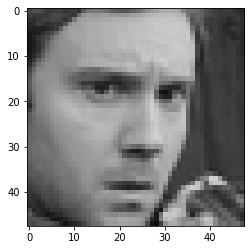

In [5]:
# Preview image
img = cv2.imread('./FERPlus/data/FER2013Train/fer0000000.png')
plt.imshow(img)
print(img.shape)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255,
                              rotation_range=5,
                              shear_range=0.1,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              )


train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./FERPlus/data/FER2013Train",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))

valid_datagen = ImageDataGenerator(rescale=1/255)
valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory="./FERPlus/data/FER2013Valid",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./FERPlus/data/FER2013Test",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))


Found 28558 validated image filenames belonging to 10 classes.
Found 3579 validated image filenames belonging to 10 classes.
Found 3573 validated image filenames belonging to 9 classes.


In [7]:
df_copy = df.copy()
useful_cols = [x for x in df_copy.columns][2:]
dfc = df_copy[useful_cols]
dfc['emotion'] = dfc.idxmax(axis=1)
df_final = pd.concat([df_copy[['usage','img_name']],  dfc[['emotion']]], axis=1, ignore_index=False)
df_final['img_name'] = df_final['img_name'].apply(str)
df_final = df_final.replace('nan', np.nan)
df_final.dropna(subset = ["img_name"], inplace=True)
df_final = df_final.reset_index(drop=True)

df_final['emotion'] = df_final['emotion'].map(di)
df_final['emotion'] = df_final['emotion'].apply(str)

df_final_test_generator=test_datagen.flow_from_dataframe(
    dataframe=df_final,
    directory="./FERPlus/data/FER2013Test",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found 3574 validated image filenames belonging to 10 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 32140 invalid image filename(s) in x_col="img_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


<AxesSubplot:>

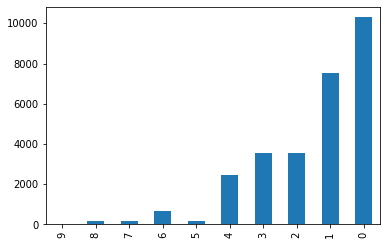

In [8]:
train_df.emotion.value_counts().sort_index(ascending=False).plot(kind='bar')

<AxesSubplot:>

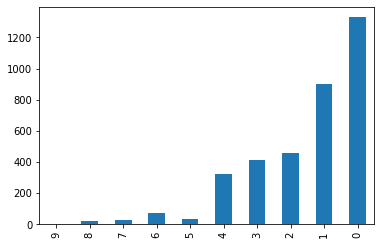

In [9]:
valid_df.emotion.value_counts().sort_index(ascending=False).plot(kind='bar')

<AxesSubplot:>

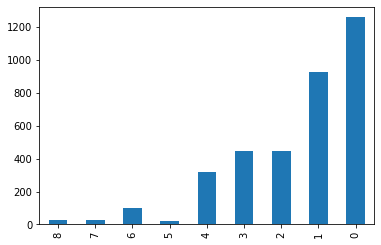

In [10]:
test_df.emotion.value_counts().sort_index(ascending=False).plot(kind='bar')

## Transfer learning

In [11]:
#importing mobilenet_v2
mobilnet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape =(48,48,3),
    alpha=1.0, include_top=False, weights='imagenet', pooling=None,     
)

2022-02-26 12:01:47.834241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 12:01:47.936666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 12:01:47.937368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 12:01:47.938641: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
mobilnet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 24, 24, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [13]:
from keras import Sequential
from keras.layers import Dense,Flatten,Dropout,MaxPooling2D,Conv2D,GlobalMaxPooling2D,BatchNormalization
np.random.seed(42)
tf.random.set_seed(42)


model = Sequential([
    mobilnet_model,
    GlobalMaxPooling2D(),
    Dense(1048, activation='relu'),
    Dropout(0.9),
    Dense(1048, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1048)              1342488   
_________________________________________________________________
dropout (Dropout)            (None, 1048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1048)              1099352   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10490     
Total params: 4,710,314
Trainable params: 4,676,202
Non-trainable params: 34,112
_________________________________________

In [14]:
history = model.fit(x = train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = 50)

2022-02-26 12:01:52.407838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-26 12:01:57.557642: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


892/892 [==============================] - 56s 50ms/step - loss: 1.9888 - accuracy: 0.3127 - val_loss: 1.5710 - val_accuracy: 0.3972
Epoch 2/50
892/892 [==============================] - 45s 50ms/step - loss: 1.5954 - accuracy: 0.4047 - val_loss: 1.5219 - val_accuracy: 0.4217
Epoch 3/50
892/892 [==============================] - 44s 49ms/step - loss: 1.4789 - accuracy: 0.4764 - val_loss: 1.4351 - val_accuracy: 0.5023
Epoch 4/50
892/892 [==============================] - 45s 51ms/step - loss: 1.3896 - accuracy: 0.5190 - val_loss: 1.2897 - val_accuracy: 0.5746
Epoch 5/50
892/892 [==============================] - 45s 50ms/step - loss: 1.3166 - accuracy: 0.5520 - val_loss: 1.2165 - val_accuracy: 0.5991
Epoch 6/50
892/892 [==============================] - 45s 51ms/step - loss: 1.2700 - accuracy: 0.5746 - val_loss: 1.2171 - val_accuracy: 0.6002
Epoch 7/50
892/892 [==============================] - 44s 50ms/step - loss: 1.1993 - accuracy: 0.6019 - val_loss: 1.1840 - val_accuracy: 0.6090
Epo

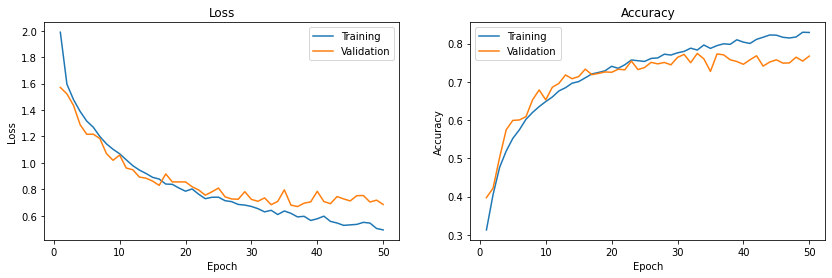

In [15]:
#validation and training loss vs epoch graph
history = history.history
n_epochs = len(history['loss'])

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [16]:
# save and quantize model
model.save('./emotion.h5')
model = tf.keras.models.load_model('./emotion.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("emotion.tflite", "wb").write(tflite_model)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-02-26 12:54:20.814117: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-02-26 12:54:37.501410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 12:54:37.501811: I tensorflow/core/grappler/devi

18678708

In [17]:
model.evaluate(df_final_test_generator)

112/112 [==============================] - 3s 15ms/step - loss: 0.7323 - accuracy: 0.7473


[0.7322887778282166, 0.7473419308662415]